<h1>Estudo de Caso - Previsão do Valor de Vacúo relacionado ao Ambiente</h1>



In [1]:
#IMPORTING ALL LIBS
import pandas as pd
import seaborn as sns
import pytz
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import plotly.express as px

from matplotlib.colors import LinearSegmentedColormap

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")


<h2> Dados Climaticos</h2>
<h3>Importando os dados climaticos</h3>
<p>Os dados foram de Julho foram baixados diretamente do site do INMET<br>https://tempo.inmet.gov.br/TabelaEstacoes/A001</p>

In [2]:
df_weather_original = pd.read_excel('weather.xlsx')
df_weather_original

df_weather = df_weather_original

df_weather

Data  Hora (UTC) Temp. Ins. (C) Temp. Max. (C) Temp. Min. (C)  \
0   2023-07-01           0           18,3           19,6           18,3   
1   2023-07-01         100           17,0           18,3           17,0   
2   2023-07-01         200           16,6           17,0           16,4   
3   2023-07-01         300           15,0           16,6           15,0   
4   2023-07-01         400           14,6           15,0           14,5   
..         ...         ...            ...            ...            ...   
739 2023-07-31        1900           23,9           24,1           23,2   
740 2023-07-31        2000           22,9           24,1           22,9   
741 2023-07-31        2100           20,6           22,9           20,6   
742 2023-07-31        2200           20,6           20,7           20,3   
743 2023-07-31        2300           18,4           20,7           18,4   

    Umi. Ins. (%) Umi. Max. (%) Umi. Min. (%) Pto Orvalho Ins. (C)  \
0            71,0          71,0          65,0                 12,9   
1            77,0          77,0          71,0                 13,0   
2            80,0          81,0          77,0                 13,1   
3            87,0          87,0          80,0                 12,9   
4            91,0          91,0          87,0                 13,2   
..            ...           ...           ...                  ...   
739          52,0          56,0          51,0                 13,3   
740          54,0          54,0          50,0                 13,0   
741          61,0          61,0          54,0                 12,8   
742          60,0          62,0          60,0                 12,6   
743          70,0          70,0          60,0                 12,9   

    Pto Orvalho Max. (C) Pto Orvalho Min. (C) Pressao Ins. (hPa)  \
0                   13,1                 12,4              957,2   
1                   13,2                 12,9              957,4   
2                   13,3                 13,0              957,5   
3                   13,2                 12,8              957,5   
4                   13,3                 12,7              957,4   
..                   ...                  ...                ...   
739                 14,5                 13,0              955,9   
740                 13,7                 12,8              956,1   
741                 13,2                 12,7              956,5   
742                 12,8                 12,6              956,9   
743                 12,9                 12,4              957,2   

    Pressao Max. (hPa) Pressao Min. (hPa) Vel. Vento (m/s) Dir. Vento (m/s)  \
0                957,2              956,9              2,4            188,0   
1                957,4              957,1              0,5            195,0   
2                957,6              957,4              0,5            197,0   
3                957,5              957,4              1,4            214,0   
4                957,5              957,3              1,3            203,0   
..                 ...                ...              ...              ...   
739              955,9              955,7              1,9            211,0   
740              956,1              955,9              1,9            214,0   
741              956,5              956,1              1,5            210,0   
742              956,9              956,5              1,1            200,0   
743              957,2              956,9              0,7            202,0   

    Raj. Vento (m/s) Radiacao (KJ/m²) Chuva (mm)  
0                4,5              NaN        0,0  
1                3,8              NaN        0,0  
2                1,8              NaN        0,0  
3                2,3              NaN        0,0  
4                2,3              NaN        0,0  
..               ...              ...        ...  
739              3,9          1374,60        0,0  
740              4,0           646,30        0,0  
741              3,3            63,90      

<h3>Tratamento dos Dados Climaticos</h3>

<p>Conversão da Unidade de Tempo e Filtragem por Data</p>

In [3]:
#Converte para o fuso horário de Brasília (BRT ou BRST)
def convert_to_brasilia_timezone(row):
    dt = pd.to_datetime(row['Data'], format='%d/%m/%Y')
    hour = row['Hora (UTC)'] // 100
    dt_utc = dt.replace(hour=hour, minute=0, second=0)
    utc_timezone = pytz.timezone('UTC')
    brasilia_timezone = pytz.timezone('America/Sao_Paulo')
    dt_brasilia = utc_timezone.localize(dt_utc).astimezone(brasilia_timezone)
    return dt_brasilia.strftime('%Y-%m-%d %H:%M:%S')


df_weather['Data'] = df_weather.apply(convert_to_brasilia_timezone, axis=1)

df_weather.drop(columns=['Hora (UTC)'], inplace=True)

df_weather.rename(columns={'Data': 'Date_Time'}, inplace=True)

df_weather['Date_Time'] = pd.to_datetime(df_weather['Date_Time'])

#Filtra os dados anteriores a 01/07/2023
data_limite = pd.to_datetime('01/07/2023', format='%d/%m/%Y')
df_weather = df_weather[df_weather['Date_Time'] >= data_limite]

df_weather



Date_Time Temp. Ins. (C) Temp. Max. (C) Temp. Min. (C)  \
3   2023-07-01 00:00:00           15,0           16,6           15,0   
4   2023-07-01 01:00:00           14,6           15,0           14,5   
5   2023-07-01 02:00:00           13,6           14,7           13,6   
6   2023-07-01 03:00:00           12,9           13,6           12,7   
7   2023-07-01 04:00:00           12,4           13,0           12,4   
..                  ...            ...            ...            ...   
739 2023-07-31 16:00:00           23,9           24,1           23,2   
740 2023-07-31 17:00:00           22,9           24,1           22,9   
741 2023-07-31 18:00:00           20,6           22,9           20,6   
742 2023-07-31 19:00:00           20,6           20,7           20,3   
743 2023-07-31 20:00:00           18,4           20,7           18,4   

    Umi. Ins. (%) Umi. Max. (%) Umi. Min. (%) Pto Orvalho Ins. (C)  \
3            87,0          87,0          80,0                 12,9   
4            91,0          91,0          87,0                 13,2   
5           100,0         100,0          91,0                 13,6   
6             NaN           NaN           NaN                  NaN   
7             NaN           NaN           NaN                  NaN   
..            ...           ...           ...                  ...   
739          52,0          56,0          51,0                 13,3   
740          54,0          54,0          50,0                 13,0   
741          61,0          61,0          54,0                 12,8   
742          60,0          62,0          60,0                 12,6   
743          70,0          70,0          60,0                 12,9   

    Pto Orvalho Max. (C) Pto Orvalho Min. (C) Pressao Ins. (hPa)  \
3                   13,2                 12,8              957,5   
4                   13,3                 12,7              957,4   
5                   13,9                 12,6              957,0   
6                    NaN                  NaN              956,5   
7                    NaN                  NaN              955,8   
..                   ...                  ...                ...   
739                 14,5                 13,0              955,9   
740                 13,7                 12,8              956,1   
741                 13,2                 12,7              956,5   
742                 12,8                 12,6              956,9   
743                 12,9                 12,4              957,2   

    Pressao Max. (hPa) Pressao Min. (hPa) Vel. Vento (m/s) Dir. Vento (m/s)  \
3                957,5              957,4              1,4            214,0   
4                957,5              957,3              1,3            203,0   
5                957,4              957,0              0,6            201,0   
6                957,0              956,5              1,0            208,0   
7                956,6              955,8              0,6            206,0   
..                 ...                ...              ...              ...   
739              955,9              955,7              1,9            211,0   
740              956,1              955,9              1,9            214,0   
741              956,5              956,1              1,5            210,0   
742              956,9              956,5              1,1            200,0   
743              957,2              956,9              0,7            202,0   

    Raj. Vento (m/s) Radiacao (KJ/m²) Chuva (mm)  
3                2,3              NaN        0,0  
4                2,3              NaN        0,0  
5                1,6              NaN        0,0  
6                2,2              NaN        0,0  
7                2,0              NaN        0,0  
..               ...              ...        ...  
739              3,9          1374,60        0,0  
740              4,0           646,30        0,0  
741              3,3            63,90        0,0  
742              2,4            

<p>Conversão dos dados para numericos</p>

In [4]:

#Converte todas as colunas, exceto 'Date_Time', para numéricos
cols_to_convert = df_weather.columns.drop('Date_Time')
df_weather[cols_to_convert] = df_weather[cols_to_convert].apply(lambda x: pd.to_numeric(x.str.replace(',', '.')))
df_weather

Date_Time  Temp. Ins. (C)  Temp. Max. (C)  Temp. Min. (C)  \
3   2023-07-01 00:00:00            15.0            16.6            15.0   
4   2023-07-01 01:00:00            14.6            15.0            14.5   
5   2023-07-01 02:00:00            13.6            14.7            13.6   
6   2023-07-01 03:00:00            12.9            13.6            12.7   
7   2023-07-01 04:00:00            12.4            13.0            12.4   
..                  ...             ...             ...             ...   
739 2023-07-31 16:00:00            23.9            24.1            23.2   
740 2023-07-31 17:00:00            22.9            24.1            22.9   
741 2023-07-31 18:00:00            20.6            22.9            20.6   
742 2023-07-31 19:00:00            20.6            20.7            20.3   
743 2023-07-31 20:00:00            18.4            20.7            18.4   

     Umi. Ins. (%)  Umi. Max. (%)  Umi. Min. (%)  Pto Orvalho Ins. (C)  \
3             87.0           87.0           80.0                  12.9   
4             91.0           91.0           87.0                  13.2   
5            100.0          100.0           91.0                  13.6   
6              NaN            NaN            NaN                   NaN   
7              NaN            NaN            NaN                   NaN   
..             ...            ...            ...                   ...   
739           52.0           56.0           51.0                  13.3   
740           54.0           54.0           50.0                  13.0   
741           61.0           61.0           54.0                  12.8   
742           60.0           62.0           60.0                  12.6   
743           70.0           70.0           60.0                  12.9   

     Pto Orvalho Max. (C)  Pto Orvalho Min. (C)  Pressao Ins. (hPa)  \
3                    13.2                  12.8               957.5   
4                    13.3                  12.7               957.4   
5                    13.9                  12.6               957.0   
6                     NaN                   NaN               956.5   
7                     NaN                   NaN               955.8   
..                    ...                   ...                 ...   
739                  14.5                  13.0               955.9   
740                  13.7                  12.8               956.1   
741                  13.2                  12.7               956.5   
742                  12.8                  12.6               956.9   
743                  12.9                  12.4               957.2   

     Pressao Max. (hPa)  Pressao Min. (hPa)  Vel. Vento (m/s)  \
3                 957.5               957.4               1.4   
4                 957.5               957.3               1.3   
5                 957.4               957.0               0.6   
6                 957.0               956.5               1.0   
7                 956.6               955.8               0.6   
..                  ...                 ...               ...   
739               955.9               955.7               1.9   
740               956.1               955.9               1.9   
741               956.5               956.1               1.5   
742               956.9               956.5               1.1   
743               957.2               956.9               0.7   

     Dir. Vento (m/s)  Raj. Vento (m/s)  Radiacao (KJ/m²)  Chuva (mm)  
3               214.0               2.3               NaN         0.0  
4               203.0               2.3               NaN         0.0  
5               201.0               1.6               NaN         0.0  
6               208.0               2.2               NaN         0.0  
7               206.0               2.0               NaN         0.0  
..                ...               ...               ...         ...  
739             211.0               3.9            1374.6         0.0  
740           

<p>Calcula as médias dos valores minimos e maximos de cada hora</p>

In [5]:
#Cria uma nova coluna 'Media' para cada atributo, usando os valores Max e Min
df_weather['Temperatura Media (C)'] = (df_weather['Temp. Max. (C)'] + df_weather['Temp. Min. (C)']) / 2
df_weather['Umidade Media (%)'] = (df_weather['Umi. Max. (%)'] + df_weather['Umi. Min. (%)']) / 2
df_weather['Pto Orvalho. Media (C)'] = (df_weather['Pto Orvalho Max. (C)'] + df_weather['Pto Orvalho Min. (C)']) / 2
df_weather['Pressao Atm Media (hPa)'] = (df_weather['Pressao Max. (hPa)'] + df_weather['Pressao Min. (hPa)']) / 2

#Remove as colunas de Minimo, Maximo e instataneo.
df_weather.drop(columns=['Temp. Max. (C)', 'Temp. Min. (C)','Temp. Ins. (C)',
                         'Umi. Ins. (%)','Umi. Max. (%)','Umi. Min. (%)',
                         'Pto Orvalho Ins. (C)','Pto Orvalho Max. (C)','Pto Orvalho Min. (C)',
                         'Pressao Ins. (hPa)','Pressao Max. (hPa)','Pressao Min. (hPa)','Chuva (mm)','Raj. Vento (m/s)','Dir. Vento (m/s)'
                         ], inplace=True)

df_weather

Date_Time  Vel. Vento (m/s)  Radiacao (KJ/m²)  \
3   2023-07-01 00:00:00               1.4               NaN   
4   2023-07-01 01:00:00               1.3               NaN   
5   2023-07-01 02:00:00               0.6               NaN   
6   2023-07-01 03:00:00               1.0               NaN   
7   2023-07-01 04:00:00               0.6               NaN   
..                  ...               ...               ...   
739 2023-07-31 16:00:00               1.9            1374.6   
740 2023-07-31 17:00:00               1.9             646.3   
741 2023-07-31 18:00:00               1.5              63.9   
742 2023-07-31 19:00:00               1.1               NaN   
743 2023-07-31 20:00:00               0.7               NaN   

     Temperatura Media (C)  Umidade Media (%)  Pto Orvalho. Media (C)  \
3                    15.80               83.5                   13.00   
4                    14.75               89.0                   13.00   
5                    14.15               95.5                   13.25   
6                    13.15                NaN                     NaN   
7                    12.70                NaN                     NaN   
..                     ...                ...                     ...   
739                  23.65               53.5                   13.75   
740                  23.50               52.0                   13.25   
741                  21.75               57.5                   12.95   
742                  20.50               61.0                   12.70   
743                  19.55               65.0                   12.65   

     Pressao Atm Media (hPa)  
3                     957.45  
4                     957.40  
5                     957.20  
6                     956.75  
7                     956.20  
..                       ...  
739                   955.80  
740                   956.00  
741                   956.30  
742                   956.70  
743                   957.05  

[741 rows x 7 columns]

<h3>Visualizando o conjunto de dados de Temperatura</h3>
<p>Comparando como as variaveis Temperatura e Umidade se relacionam</p>

In [6]:

#Converte a coluna 'Date_Time' para o formato datetime
df_weather['Date_Time'] = pd.to_datetime(df_weather['Date_Time'])

#Cria o gráfico
fig_temp_umid = go.Figure()

fig_temp_umid.add_trace(go.Scatter(x=df_weather['Date_Time'], y=df_weather['Temperatura Media (C)'],
                                  mode='lines', name='Temperatura Média (C)'))
fig_temp_umid.update_layout(yaxis=dict(title='Temperatura Média (C)'))
fig_temp_umid.update_layout(yaxis2=dict(title='Umidade Média (%)', overlaying='y', side='right'))
fig_temp_umid.add_trace(go.Scatter(x=df_weather['Date_Time'], y=df_weather['Umidade Media (%)'],
                                  mode='lines', name='Umidade Média (%)', yaxis='y2'))
fig_temp_umid.update_layout(title='Variação da Temperatura Média e Umidade Média ao longo do tempo',
                            xaxis_title='Data e Hora')
fig_temp_umid.show()

<p>Analisando como são as variações de temperatura no passar do mês </p>

In [7]:
#Extrai a data (sem a informação de hora) para calcular as temperaturas máximas e mínimas por dia
df_weather['Date'] = df_weather['Date_Time'].dt.date

#Calcula as temperaturas máximas e mínimas por dia
max_temps_by_day = df_weather.groupby('Date')['Temperatura Media (C)'].max().reset_index()
min_temps_by_day = df_weather.groupby('Date')['Temperatura Media (C)'].min().reset_index()

#Cria o gráfico de barras
fig_temps_by_day = go.Figure()

fig_temps_by_day.add_trace(go.Bar(x=max_temps_by_day['Date'], y=max_temps_by_day['Temperatura Media (C)'],
                                 name='Temperatura Máxima (C)'))
fig_temps_by_day.add_trace(go.Bar(x=min_temps_by_day['Date'], y=min_temps_by_day['Temperatura Media (C)'],
                                 name='Temperatura Mínima (C)'))

fig_temps_by_day.update_layout(title='Temperaturas Máximas e Mínimas por Dia',
                               xaxis_title='Data', yaxis_title='Temperatura (C)',
                               barmode='group')

fig_temps_by_day.show()

<h2> Dados de Vacuo</h2>
<p>Importando os dados de vacuo de um processo produtivo (na mesma região de onde foram tiradas as temperaturas)</p>

In [16]:
df_torr_orginal = pd.read_excel('torr.xlsx')
df_torr = df_torr_orginal 
df_torr['Vacuum (TORR)'] = df_torr['Vacuum (TORR)'].apply(lambda x: pd.to_numeric(x.replace(',', '.')))
df_torr

SEQ            StartTime  Vacuum (TORR)
0      840  2023-07-01 00:01:11           1.57
1      841  2023-07-01 00:02:19           2.05
2      842  2023-07-01 00:03:42           1.67
3      843  2023-07-01 00:04:50           3.37
4      844  2023-07-01 00:06:07           2.87
...    ...                  ...            ...
20683  708  2023-07-31 23:52:58           4.01
20684  709  2023-07-31 23:54:33           4.48
20685  710  2023-07-31 23:55:54           4.42
20686  711  2023-07-31 23:57:26           3.20
20687  712  2023-07-31 23:58:44           6.27

[20688 rows x 3 columns]

<p>Adaptando os dados</p>

In [17]:
#Remove a coluna 'SEQ'
df_torr.drop('SEQ', axis=1, inplace=True)

#Converte a coluna StartTime para datetime
df_torr['StartTime'] = pd.to_datetime(df_torr['StartTime'])

df_torr

StartTime  Vacuum (TORR)
0     2023-07-01 00:01:11           1.57
1     2023-07-01 00:02:19           2.05
2     2023-07-01 00:03:42           1.67
3     2023-07-01 00:04:50           3.37
4     2023-07-01 00:06:07           2.87
...                   ...            ...
20683 2023-07-31 23:52:58           4.01
20684 2023-07-31 23:54:33           4.48
20685 2023-07-31 23:55:54           4.42
20686 2023-07-31 23:57:26           3.20
20687 2023-07-31 23:58:44           6.27

[20688 rows x 2 columns]

<h2>Juntando os Datasets</h2>


In [18]:

#Realiza o left join usando as colunas StartTime e Date_Time
df_merged = pd.merge_asof(df_torr, df_weather, left_on='StartTime', right_on='Date_Time')

#Remove a coluna redundante Date_Time do dataframe resultante
df_merged.drop('Date_Time', axis=1, inplace=True)
df_merged.drop(columns=['Date'], inplace=True)


#Elimina a coluna "Radiacao (KJ/m²)"
df_merged = df_merged.drop("Radiacao (KJ/m²)", axis=1)

#Elimina as linhas com valores ausentes em qualquer coluna
df_merged = df_merged.dropna()

df_merged


StartTime  Vacuum (TORR)  Vel. Vento (m/s)  \
0     2023-07-01 00:01:11           1.57               1.4   
1     2023-07-01 00:02:19           2.05               1.4   
2     2023-07-01 00:03:42           1.67               1.4   
3     2023-07-01 00:04:50           3.37               1.4   
4     2023-07-01 00:06:07           2.87               1.4   
...                   ...            ...               ...   
20683 2023-07-31 23:52:58           4.01               0.7   
20684 2023-07-31 23:54:33           4.48               0.7   
20685 2023-07-31 23:55:54           4.42               0.7   
20686 2023-07-31 23:57:26           3.20               0.7   
20687 2023-07-31 23:58:44           6.27               0.7   

       Temperatura Media (C)  Umidade Media (%)  Pto Orvalho. Media (C)  \
0                      15.80               83.5                   13.00   
1                      15.80               83.5                   13.00   
2                      15.80               83.5                   13.00   
3                      15.80               83.5                   13.00   
4                      15.80               83.5                   13.00   
...                      ...                ...                     ...   
20683                  19.55               65.0                   12.65   
20684                  19.55               65.0                   12.65   
20685                  19.55               65.0                   12.65   
20686                  19.55               65.0                   12.65   
20687                  19.55               65.0                   12.65   

       Pressao Atm Media (hPa)  
0                       957.45  
1                       957.45  
2                       957.45  
3                       957.45  
4                       957.45  
...                        ...  
20683                   957.05  
20684                   957.05  
20685                   957.05  
20686                   957.05  
20687                   957.05  

[17778 rows x 7 columns]

<h3>Como as variaveis se relacionam?</h3>
<p>Verificando se algum par de variaveis tem relações lineares diretas ou inversas</p>

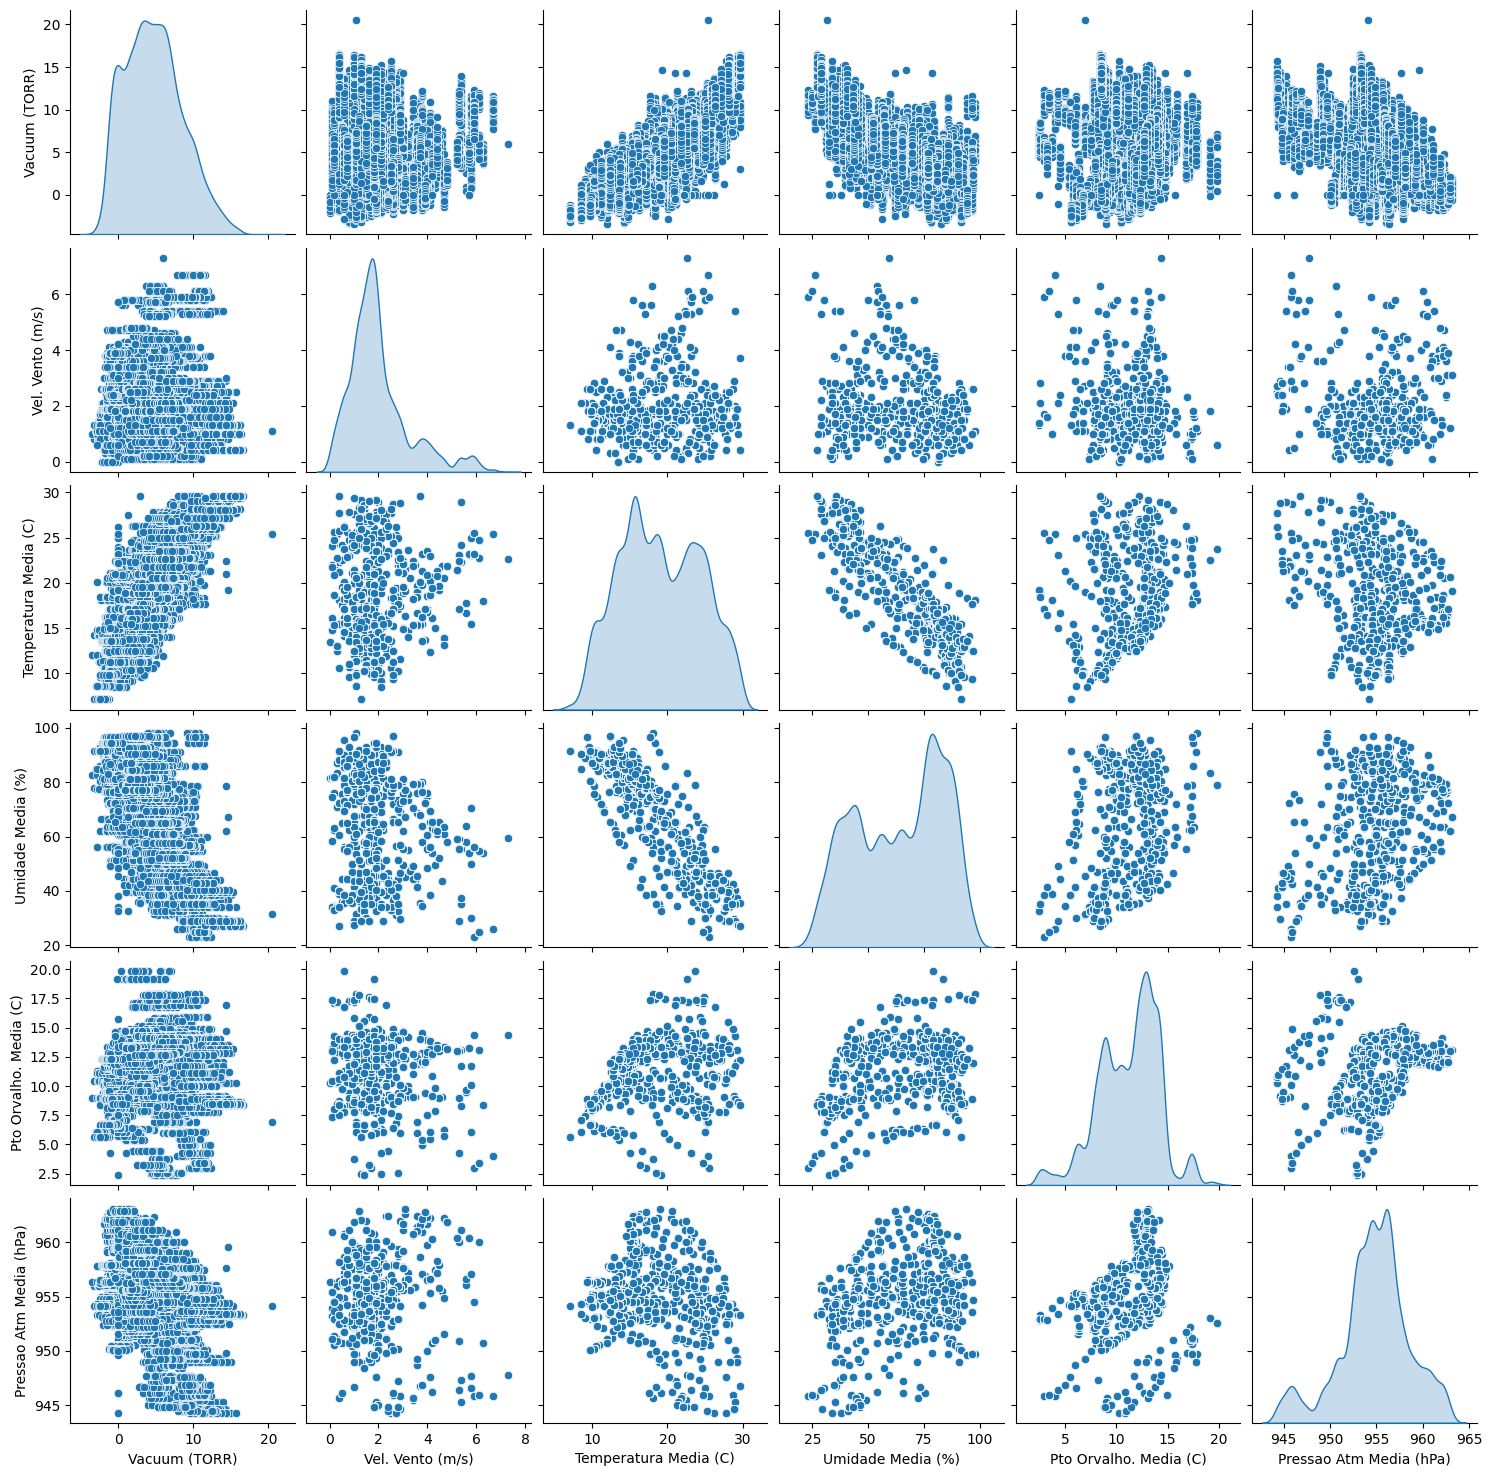

In [19]:

# Pair plot usando o Seaborn
g = sns.pairplot(df_merged, diag_kind='kde')
g.add_legend()
plt.show()

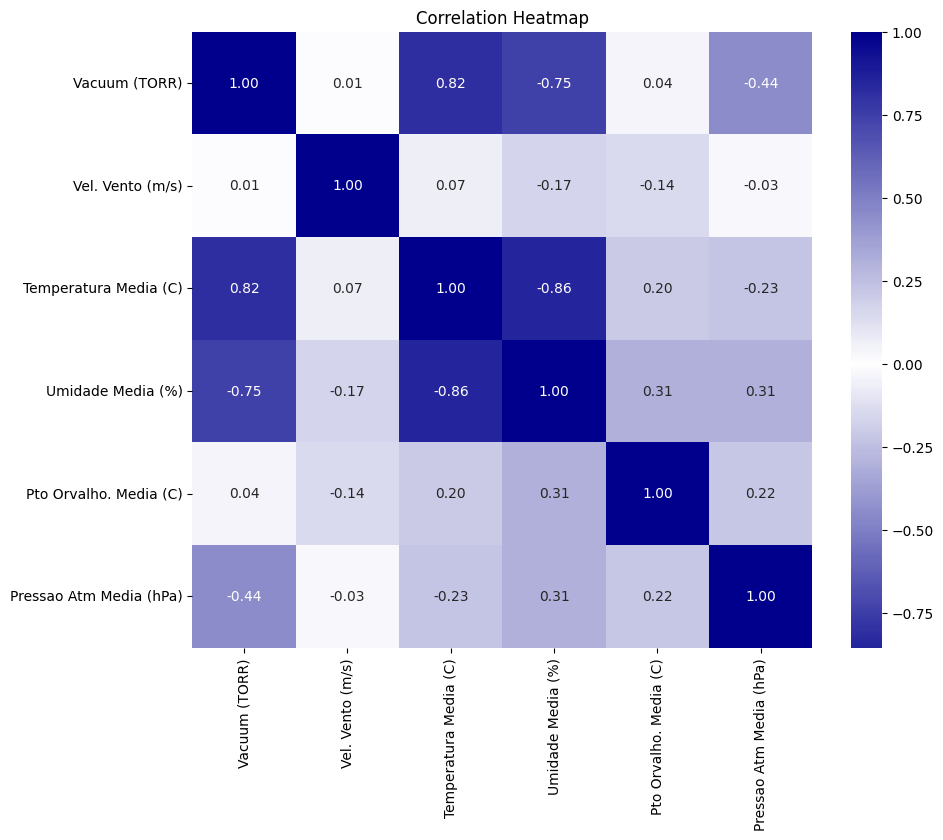

In [20]:
#Cria uma paleta personalizada com degradê
colors = [(0, 0, 0.55), (1,1, 1), (0, 0, 0.55)]

#Cria uma paleta de cores baseada na lista de cores personalizada
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

#Calcula a matriz de correlação
correlation_matrix = df_merged.corr()

#Plota o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, center=0, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# #Calcula a matriz de correlação de Spearman
# correlation_matrix = df_merged.corr(method='spearman')

# #Plota o heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f")
# plt.title("Correlation Heatmap - Spearman")
# plt.show()


<p>O vacuo, nosso valor alvo, tem fortes relações com as variaveis de Temperatura e Pressão<br>Vamos analisar como a variação do valor de vácuo se comporta junto com a variação de temperatura ao longo do dia</p>

In [21]:
#Cria o gráfico
fig_temp_umid = go.Figure()

fig_temp_umid.add_trace(go.Scatter(x=df_merged['StartTime'], y=df_merged['Temperatura Media (C)'],
                                  mode='lines', name='Temperatura Média (C)'))
fig_temp_umid.update_layout(yaxis=dict(title='Average Temperature (C)'))
fig_temp_umid.update_layout(yaxis2=dict(title='Vacuum (TORR)', overlaying='y', side='right'))
fig_temp_umid.add_trace(go.Scatter(x=df_merged['StartTime'], y=df_merged['Vacuum (TORR)'],
                                  mode='lines', name='Vacuum (TORR)', yaxis='y2'))

fig_temp_umid.update_layout(title='Variation of Average Temperature and Vacuum over Time',
                            xaxis_title='Time')

fig_temp_umid.show()

<p>Analisando como isso se comporta nos dias em que houveram maiores variações de temperatura ao longo do dia</p>

In [23]:
#Calcula a diferença entre a temperatura máxima e mínima para cada dia
df_merged['Diferenca_Temp'] = df_merged.groupby(df_merged['StartTime'].dt.date)['Temperatura Media (C)'].transform(lambda x: x.max() - x.min())

#Classifica o DataFrame pela diferença de temperatura em ordem decrescente
df_sorted = df_merged.sort_values(by='Diferenca_Temp', ascending=False)

#Seleciona os três dias com as maiores diferenças de temperatura
top_3_days = df_sorted['StartTime'].dt.date.unique()[:3]

print(top_3_days)

# Criar a função para plotar o gráfico
def plot_graph_for_date(df, date):
    df_filtered = df[df['StartTime'].dt.date == date]
    fig_temp_umid = go.Figure()

    fig_temp_umid.add_trace(go.Scatter(x=df_filtered['StartTime'], y=df_filtered['Temperatura Media (C)'],
                                      mode='lines', name='Average Temperature (C)'))

    fig_temp_umid.update_layout(yaxis=dict(title='Average Temperature (C)'))
    fig_temp_umid.update_layout(yaxis2=dict(title='Vacuum (TORR)', overlaying='y', side='right'))
    fig_temp_umid.add_trace(go.Scatter(x=df_filtered['StartTime'], y=df_filtered['Vacuum (TORR)'],
                                      mode='lines', name='Vacuum (TORR)', yaxis='y2'))
    fig_temp_umid.update_layout(title=f'Variation of Average Temperature and Vacuum over time {date}',
                                xaxis_title='Date and Time')

    fig_temp_umid.show()

datas = [pd.to_datetime('2023-07-27'), pd.to_datetime('2023-07-07'), pd.to_datetime('2023-07-05')]

#Plota o gráfico para cada data
for data in datas:
    plot_graph_for_date(df_merged, data.date())

[datetime.date(2023, 7, 27) datetime.date(2023, 7, 7)
 datetime.date(2023, 7, 5)]


In [24]:
#Extrai apenas o horário da coluna "StartTime" e atribuir à nova coluna "Time"
df_merged['Time'] = df_merged['StartTime'].dt.time
df_merged



StartTime  Vacuum (TORR)  Vel. Vento (m/s)  \
0     2023-07-01 00:01:11           1.57               1.4   
1     2023-07-01 00:02:19           2.05               1.4   
2     2023-07-01 00:03:42           1.67               1.4   
3     2023-07-01 00:04:50           3.37               1.4   
4     2023-07-01 00:06:07           2.87               1.4   
...                   ...            ...               ...   
20683 2023-07-31 23:52:58           4.01               0.7   
20684 2023-07-31 23:54:33           4.48               0.7   
20685 2023-07-31 23:55:54           4.42               0.7   
20686 2023-07-31 23:57:26           3.20               0.7   
20687 2023-07-31 23:58:44           6.27               0.7   

       Temperatura Media (C)  Umidade Media (%)  Pto Orvalho. Media (C)  \
0                      15.80               83.5                   13.00   
1                      15.80               83.5                   13.00   
2                      15.80               83.5                   13.00   
3                      15.80               83.5                   13.00   
4                      15.80               83.5                   13.00   
...                      ...                ...                     ...   
20683                  19.55               65.0                   12.65   
20684                  19.55               65.0                   12.65   
20685                  19.55               65.0                   12.65   
20686                  19.55               65.0                   12.65   
20687                  19.55               65.0                   12.65   

       Pressao Atm Media (hPa)  Diferenca_Temp      Time  
0                       957.45            1.65  00:01:11  
1                       957.45            1.65  00:02:19  
2                       957.45            1.65  00:03:42  
3                       957.45            1.65  00:04:50  
4                       957.45            1.65  00:06:07  
...                        ...             ...       ...  
20683                   957.05           10.05  23:52:58  
20684                   957.05           10.05  23:54:33  
20685                   957.05           10.05  23:55:54  
20686                   957.05           10.05  23:57:26  
20687                   957.05           10.05  23:58:44  

[17778 rows x 9 columns]

<h2>Predição do Valor de Vácuo</h2>
<p>Separando o dataset em treino e teste</p>

In [25]:
# Extrair apenas o horário da coluna "StartTime" e converter para representação numérica em segundos
df_merged['Time(s)'] = df_merged['StartTime'].dt.hour * 3600 + df_merged['StartTime'].dt.minute * 60 + df_merged['StartTime'].dt.second

# Dividir o dataframe em atributos (features) e o valor a ser previsto (target)
X = df_merged[['Time(s)', 'Temperatura Media (C)', 'Umidade Media (%)']]
y = df_merged['Vacuum (TORR)']

# Filtrar os dados de teste com base nas datas especificadas
dates_test = ['2023-07-28', '2023-07-27', '2023-07-26', '2023-07-25', '2023-07-24']
df_test = df_merged[df_merged['StartTime'].dt.date.isin(pd.to_datetime(dates_test).date)]

# Filtrar os dados de treinamento (excluindo os dados de teste)
df_train = df_merged[~df_merged['StartTime'].dt.date.isin(pd.to_datetime(dates_test).date)]

# Dividir os dados em conjunto de treinamento e conjunto de teste
X_train = df_train[['Time(s)', 'Temperatura Media (C)', 'Umidade Media (%)']]
y_train = df_train['Vacuum (TORR)']

X_test = df_test[['Time(s)', 'Temperatura Media (C)', 'Umidade Media (%)']]
y_test = df_test['Vacuum (TORR)']

<h3>Regressão Linear</h3>

In [26]:


#Cria o modelo de regressão linear
model = LinearRegression()

model.fit(X_train, y_train)
y_pred_antes = model.predict(X_test)

#Avalia o desempenho do modelo
mse = mean_squared_error(y_test, y_pred_antes)
r2 = r2_score(y_test, y_pred_antes)
mae = mean_absolute_error(y_test, y_pred_antes)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

#Acessa os coeficientes do modelo
coeficientes = model.coef_
intercepcao = model.intercept_

coeficientes_regressao_linear = np.append(coeficientes, intercepcao)

nomes_variaveis = X.columns.tolist()

#Monta a fórmula da regressão linear
formula = "y = "
for i in range(len(coeficientes)):
    formula += f"{coeficientes[i]} * {nomes_variaveis[i]} + "
formula += str(intercepcao)

print(f"Fórmula da regressão linear:\n{formula}")


Mean Absolute Error: 2.482912970304735
Mean Squared Error: 7.954073359593187
R-squared: 0.4083416572296623
Fórmula da regressão linear:
y = 1.1227330592887007e-05 * Time(s) + 0.40643888360498737 * Temperatura Media (C) + -0.04079802046349773 * Umidade Media (%) + -1.4514194955128707


<h3>Regressão Polinomial</h3>

In [27]:
#Cria um objeto PolynomialFeatures para transformar as variáveis de entrada em termos polinomiais
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

#Cria o modelo de regressão linear
model = LinearRegression()

model.fit(X_train_poly, y_train)
y_pred_poly = model.predict(X_test_poly)

#Avalia o desempenho do modelo
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
mae = mean_absolute_error(y_test, y_pred_poly)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error (Regressão Polinomial): {mse_poly}')
print(f'R-squared (Regressão Polinomial): {r2_poly}')


#Acessa os coeficientes do modelo
names = poly.get_feature_names_out()
coeficientes = model.coef_
intercepcao = model.intercept_

print(names)

#Monta a fórmula da regressão polinomial
formula = "y = "
for i in range(len(coeficientes)):
    formula += f"[{coeficientes[i]} * ({names[i]})] + "
formula += str(intercepcao)


print(f"Fórmula da regressão polinomial:\n{formula}")

Mean Absolute Error: 2.118457350821849
Mean Squared Error (Regressão Polinomial): 6.1205314536282005
R-squared (Regressão Polinomial): 0.5447284261767738
['1' 'Time(s)' 'Temperatura Media (C)' 'Umidade Media (%)' 'Time(s)^2'
 'Time(s) Temperatura Media (C)' 'Time(s) Umidade Media (%)'
 'Temperatura Media (C)^2' 'Temperatura Media (C) Umidade Media (%)'
 'Umidade Media (%)^2']
Fórmula da regressão polinomial:
y = [0.0 * (1)] + [-0.00018276083421959265 * (Time(s))] + [-2.318164676107104 * (Temperatura Media (C))] + [-0.8690979832580571 * (Umidade Media (%))] + [1.3015070927187202e-09 * (Time(s)^2)] + [4.6404693274115615e-06 * (Time(s) Temperatura Media (C))] + [8.041392701672469e-08 * (Time(s) Umidade Media (%))] + [0.039127075581900005 * (Temperatura Media (C)^2)] + [0.017885630328085593 * (Temperatura Media (C) Umidade Media (%))] + [0.003911279976478739 * (Umidade Media (%)^2)] + 51.22581507345696


<p>Testando a formula obtida</p>

In [28]:
#Função para calcular o valor previsto de Y usando a fórmula da regressão polinomial
def calcular_y(row):
    time = row['Time(s)']
    temp_media = row['Temperatura Media (C)']
    umidade_media = row['Umidade Media (%)']

    y_pred = intercepcao + coeficientes[1] * time + coeficientes[2] * temp_media + coeficientes[3] * umidade_media + \
             coeficientes[4] * time**2 + coeficientes[5] * time * temp_media + coeficientes[6] * time * umidade_media + \
             coeficientes[7] * temp_media**2 + coeficientes[8] * temp_media * umidade_media + coeficientes[9] * umidade_media**2
            
    return y_pred

#Calcula os valores previstos de 'y' para o conjunto de teste
y_pred_test = X_test.apply(calcular_y, axis=1)

In [29]:
for i in range(len(y_pred_test)):
    print(y_pred_test.values[i],";",y_pred_poly[i])

2.212112661220729 ; 2.212112661220715
2.0233558007442483 ; 2.0233558007442483
2.0115173069525483 ; 2.0115173069525483
2.0037733468065753 ; 2.0037733468065753
1.9931304706800788 ; 1.9931304706800788
1.9856157863910013 ; 1.9856157863910013
1.9778369095305308 ; 1.9778369095305308
1.9672752162104459 ; 1.9672752162104459
1.9597248967749508 ; 1.9597248967749508
1.9504270720342092 ; 1.9504270720342092
1.9415256494405568 ; 1.9415256494405568
1.933479456509481 ; 1.9334794565094953
1.9260058843442422 ; 1.9260058843442422
1.917630020137743 ; 1.917630020137743
1.910284427650133 ; 1.910284427650133
1.9026809835337204 ; 1.9026809835337204
1.892631760881038 ; 1.892631760881038
1.88534301822326 ; 1.88534301822326
1.8774354201794736 ; 1.8774354201794594
1.8694569734133708 ; 1.8694569734133708
1.862221332244978 ; 1.862221332244978
1.8532902903062691 ; 1.853290290306255
1.8464514469431137 ; 1.8464514469431137
1.8390895572192747 ; 1.8390895572192747
1.8301353303510197 ; 1.8301353303510197
1.82227714284029

<h3>Gradient Boosting</h3>

In [30]:
#Cria o modelo Gradient Boosting Regressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred_gb = model.predict(X_test)

#Avalia o desempenho do modelo
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_gb)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error (Gradient Boosting): {mse_gb}')
print(f'R-squared (Gradient Boosting): {r2_gb}')



Mean Absolute Error: 2.195772146811508
Mean Squared Error (Gradient Boosting): 6.793872781063198
R-squared (Gradient Boosting): 0.49464238901086244


<h3>Random Forest</h3>

In [31]:
#Cria o modelo Random Forest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred_rf = model.predict(X_test)

#Avalia o desempenho do modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'R-squared (Random Forest): {r2_rf}')


Mean Absolute Error: 2.477972190119911
Mean Squared Error (Random Forest): 8.88310616062715
R-squared (Random Forest): 0.3392361835196296


<h3>Compara as previsoes dos modelos</h3>

In [32]:
# Criar um gráfico de linhas para os dados reais e previstos pelo Linear Regression
fig_t = go.Figure()
fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_test, mode='lines', name='Dados Reais', marker=dict(color='black')))
fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_pred_antes, mode='lines', name='Dados Previstos (Linear Regression)', marker=dict(color='blue')))
fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_pred_rf, mode='lines', name='Dados Previstos (Random Forest)', marker=dict(color='green')))
fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_pred_gb, mode='lines', name='Dados Previstos (Gradient Boosting)', marker=dict(color='red')))
fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_pred_poly, mode='lines', name='Dados Previstos (Poly Regression)', marker=dict(color='orange')))
#fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_pred_test.values, mode='lines', name='Dados Previstos (Formula)', marker=dict(color='green')))

fig_t.update_layout(title='Previsão de Vacuum (TORR)',
                      xaxis_title='Data e Hora',
                      yaxis_title='Vacuum (TORR)')
fig_t.show()

<p>Analisa apenas os resultados das regressões, modelos em que se é possivel extrair uma formula</p>

In [33]:
# Criar um gráfico de linhas para os dados reais e previstos pelo Linear Regression
fig_t = go.Figure()
fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_test, mode='lines', name='Dados Reais', marker=dict(color='black')))
fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_pred_antes, mode='lines', name='Dados Previstos (Linear Regression)', marker=dict(color='blue')))
fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_pred_poly, mode='lines', name='Dados Previstos (Poly Regression)', marker=dict(color='orange')))
#fig_t.add_trace(go.Scatter(x=df_test['StartTime'], y=y_pred_test.values, mode='lines', name='Dados Previstos (Formula)', marker=dict(color='green')))

fig_t.update_layout(title='Previsão de Vacuum (TORR)',
                      xaxis_title='Data e Hora',
                      yaxis_title='Vacuum (TORR)')
fig_t.show()

In [34]:
# import plotly.io as pio

# pio.renderers.default = 'notebook'

# fig = px.scatter_3d(df_merged,x=df_merged['Temperatura Media (C)'],y=df_merged['Time(s)'], z = df_merged['Umidade Media (%)'],color=df_merged['Time(s)'])

# fig.show()
# #X = df_merged[['Time(s)', 'Temperatura Media (C)', 'Umidade Media (%)']]